In [4]:
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt

# Generate and then plot the data

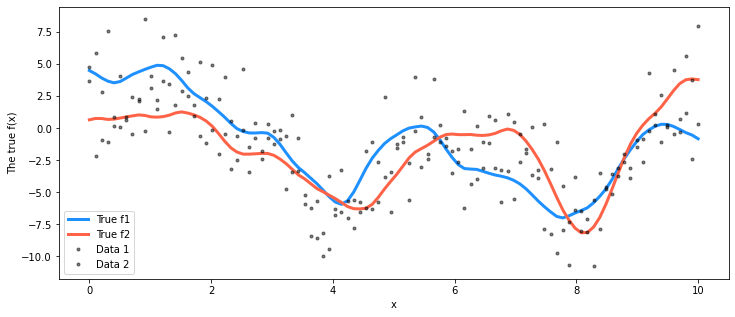

In [7]:
import numpy as np
import pymc3 as pm

# set the seed
np.random.seed(1)

n = 100 
x = np.linspace(0, 10, n)[:, None] 

# true covariance function and its true parameters
ℓ_true = 1.0
eta_true = 3.0
cov_func = eta_true**2 * pm.gp.cov.Matern52(1, ℓ_true)
mean_func = pm.gp.mean.Zero()

# two samples from the same gaussian process
f_true1 = np.random.multivariate_normal(mean_func(x1).eval(),
                                        cov_func(x1).eval() + 1e-8*np.eye(n), 1).flatten()
f_true2 = np.random.multivariate_normal(mean_func(x2).eval(),
                                        cov_func(x2).eval() + 1e-8*np.eye(n), 1).flatten()


sigma_true = 2.0
f1 = 0.5*f_true1 - 1.0*f_true2
f2 = 1.0*f_true1 + 0.2*f_true2
y1 = f1 + sigma_true * np.random.randn(n)
y2 = f2 + sigma_true * np.random.randn(n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(x, f1, "dodgerblue", lw=3, label="True f1");
ax.plot(x, f2, "tomato", lw=3, label="True f2");
ax.plot(x, y1, 'ok', ms=3, alpha=0.5, label="Data 1");
ax.plot(x, y2, 'ok', ms=3, alpha=0.5, label="Data 2");
ax.set_xlabel("x"); ax.set_ylabel("The true f(x)"); plt.legend();

# Format the data for the coregionalized GP

In [8]:
xx = np.concatenate((x, x), axis=0)
idx = np.concatenate((np.zeros(n), np.ones(n)))[:,None]
X = np.concatenate((xx, idx), axis=1)

y = np.concatenate((y1, y2))
X.shape, y.shape

((200, 2), (200,))

# pymc3 model

In [9]:
with pm.Model() as model_cor:
    eta = pm.Gamma("eta", alpha=2, beta=0.5)
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell, active_dims=[0])
    
    W = pm.Normal("W", mu=0, sd=3, shape=(2,2), testval=np.random.randn(2,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=2)
    coreg = pm.gp.cov.Coregion(input_dim=2, active_dims=[1], kappa=kappa, W=W)
    cov_func = coreg * cov

    sigma = pm.HalfNormal("sigma", sd=3)
    gp = pm.gp.Marginal(cov_func=cov_func)
    y_ = gp.marginal_likelihood("f", X, y, noise=sigma) 

/home/mach1ne/anaconda3/envs/bayesian_analysis_with_python/lib/python3.8/site-packages/pymc3/gp/cov.py:90: UserWarning: Only 1 column(s) out of 2 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(f"Only {self.input_dim} column(s) out of {X.shape[-1]} are"


# MAP estimate and generate some predictions

In [10]:
with model_cor:
    mp = pm.find_MAP()

In [11]:
x_new = np.linspace(0, 20, 200)[:,None]
xx_new = np.concatenate((x_new, x_new), axis=0)
idx2 = np.concatenate((np.zeros(200), np.ones(200)))[:,None]
X_new = np.concatenate((xx_new, idx2), axis=1)

with model_cor:
    f_pred = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model_cor:
    pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=300)

/home/mach1ne/anaconda3/envs/bayesian_analysis_with_python/lib/python3.8/site-packages/pymc3/gp/cov.py:90: UserWarning: Only 1 column(s) out of 2 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(f"Only {self.input_dim} column(s) out of {X.shape[-1]} are"
/home/mach1ne/anaconda3/envs/bayesian_analysis_with_python/lib/python3.8/site-packages/pymc3/gp/cov.py:90: UserWarning: Only 1 column(s) out of 2 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(f"Only {self.input_dim} column(s) out of {X.shape[-1]} are"


# plot

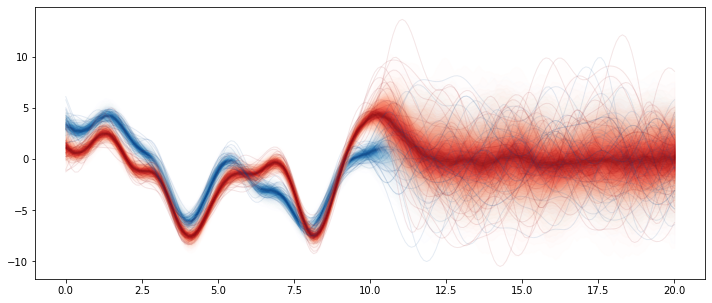

In [12]:
from pymc3.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

f_pred = pred_samples["f_pred"]
plot_gp_dist(ax, f_pred[:, :200], X_new[:200,0], palette="Blues", fill_alpha=0.1, samples_alpha=0.1);
plot_gp_dist(ax, f_pred[:, 200:], X_new[200:,0], palette="Reds", fill_alpha=0.1, samples_alpha=0.1);